In [30]:
import pandas as pd
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import transformers
from tensorflow.keras.models import Model
from keras.layers.core import Dense, Dropout
from transformers import TFBertModel,  BertConfig, BertTokenizerFast
import matplotlib.pyplot as plt
import numpy as np

In [4]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

Running on TPU  grpc://10.0.0.2:8470


In [5]:
train = pd.read_csv('../input/dataset-modified/train_modified.csv')
valid = pd.read_csv('../input/dataset-modified/val_modified.csv')
test = pd.read_csv('../input/dataset-modified/test_modified.csv')

xtrain, ytrain = train.Comment.values, train.Emotion.values
xvalid, yvalid = valid.Comment.values, valid.Emotion.values
xtest, ytest = test.Comment.values, test.Emotion.values

In [7]:
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = 'bert-base-multilingual-cased')
max_len = 200

xtrain_pad = tokenizer(
    text=train['Comment'].to_list(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)

xvalid_pad = tokenizer(
    text=valid['Comment'].to_list(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)

In [8]:
def build_model(transformer):
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    sequence_output = transformer(input_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(4, activation='softmax')(cls_token)

    model = Model(inputs=input_ids, outputs=out)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(Adam(lr=1e-5, beta_2 = 0.99), loss=loss, metrics=['accuracy'])

    return model

In [35]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

with strategy.scope():
    model_name = 'bert-base-multilingual-cased'
    config = BertConfig.from_pretrained(model_name)
    config.output_hidden_states = False
    transformer_model = TFBertModel.from_pretrained(model_name, config = config)
    model = build_model(transformer_model)
    
model.summary()

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 200)]             0         
_________________________________________________________________
tf_bert_model_2 (TFBertModel ((None, 200, 768), (None, 177853440 
_________________________________________________________________
tf_op_layer_strided_slice_2  [(None, 768)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 3076      
Total params: 177,856,516
Trainable params: 177,856,516
Non-trainable params: 0
_________________________________________________________________


In [36]:
history = model.fit(xtrain_pad['input_ids'], ytrain,epochs=100, validation_data= (xvalid_pad['input_ids'], yvalid), batch_size=32) 

Epoch 1/100
94/94 [==============================] - ETA: 0s - loss: 1.3739 - accuracy: 0.28 - ETA: 4s - loss: 1.3691 - accuracy: 0.28 - ETA: 5s - loss: 1.3717 - accuracy: 0.27 - ETA: 6s - loss: 1.3779 - accuracy: 0.27 - ETA: 6s - loss: 1.3778 - accuracy: 0.29 - ETA: 6s - loss: 1.3809 - accuracy: 0.28 - ETA: 7s - loss: 1.3795 - accuracy: 0.27 - ETA: 7s - loss: 1.3821 - accuracy: 0.26 - ETA: 7s - loss: 1.3834 - accuracy: 0.26 - ETA: 7s - loss: 1.3860 - accuracy: 0.27 - ETA: 7s - loss: 1.3885 - accuracy: 0.26 - ETA: 7s - loss: 1.3852 - accuracy: 0.27 - ETA: 7s - loss: 1.3856 - accuracy: 0.27 - ETA: 7s - loss: 1.3864 - accuracy: 0.27 - ETA: 6s - loss: 1.3893 - accuracy: 0.26 - ETA: 6s - loss: 1.3933 - accuracy: 0.25 - ETA: 6s - loss: 1.3936 - accuracy: 0.25 - ETA: 6s - loss: 1.3925 - accuracy: 0.26 - ETA: 6s - loss: 1.3927 - accuracy: 0.25 - ETA: 6s - loss: 1.3937 - accuracy: 0.26 - ETA: 6s - loss: 1.3935 - accuracy: 0.25 - ETA: 6s - loss: 1.3940 - accuracy: 0.25 - ETA: 6s - loss: 1.3954 

Epoch 3/100
94/94 [==============================] - ETA: 0s - loss: 0.8719 - accuracy: 0.87 - ETA: 4s - loss: 0.9170 - accuracy: 0.81 - ETA: 5s - loss: 0.9454 - accuracy: 0.79 - ETA: 6s - loss: 0.9677 - accuracy: 0.77 - ETA: 6s - loss: 0.9652 - accuracy: 0.78 - ETA: 6s - loss: 0.9481 - accuracy: 0.80 - ETA: 6s - loss: 0.9349 - accuracy: 0.82 - ETA: 6s - loss: 0.9340 - accuracy: 0.82 - ETA: 6s - loss: 0.9413 - accuracy: 0.81 - ETA: 6s - loss: 0.9466 - accuracy: 0.80 - ETA: 6s - loss: 0.9560 - accuracy: 0.79 - ETA: 6s - loss: 0.9603 - accuracy: 0.78 - ETA: 6s - loss: 0.9681 - accuracy: 0.78 - ETA: 6s - loss: 0.9716 - accuracy: 0.77 - ETA: 6s - loss: 0.9669 - accuracy: 0.78 - ETA: 6s - loss: 0.9669 - accuracy: 0.78 - ETA: 6s - loss: 0.9661 - accuracy: 0.78 - ETA: 6s - loss: 0.9687 - accuracy: 0.78 - ETA: 6s - loss: 0.9684 - accuracy: 0.78 - ETA: 6s - loss: 0.9691 - accuracy: 0.78 - ETA: 6s - loss: 0.9661 - accuracy: 0.78 - ETA: 6s - loss: 0.9678 - accuracy: 0.77 - ETA: 6s - loss: 0.9633 

Epoch 5/100
94/94 [==============================] - ETA: 0s - loss: 0.8425 - accuracy: 0.90 - ETA: 4s - loss: 0.9408 - accuracy: 0.81 - ETA: 5s - loss: 0.9686 - accuracy: 0.78 - ETA: 6s - loss: 0.9350 - accuracy: 0.81 - ETA: 6s - loss: 0.9336 - accuracy: 0.81 - ETA: 6s - loss: 0.9576 - accuracy: 0.78 - ETA: 6s - loss: 0.9550 - accuracy: 0.79 - ETA: 6s - loss: 0.9512 - accuracy: 0.79 - ETA: 6s - loss: 0.9484 - accuracy: 0.79 - ETA: 6s - loss: 0.9412 - accuracy: 0.80 - ETA: 6s - loss: 0.9516 - accuracy: 0.78 - ETA: 6s - loss: 0.9371 - accuracy: 0.80 - ETA: 6s - loss: 0.9387 - accuracy: 0.80 - ETA: 6s - loss: 0.9363 - accuracy: 0.80 - ETA: 6s - loss: 0.9342 - accuracy: 0.80 - ETA: 6s - loss: 0.9290 - accuracy: 0.81 - ETA: 6s - loss: 0.9300 - accuracy: 0.81 - ETA: 6s - loss: 0.9331 - accuracy: 0.80 - ETA: 6s - loss: 0.9314 - accuracy: 0.81 - ETA: 6s - loss: 0.9318 - accuracy: 0.80 - ETA: 6s - loss: 0.9301 - accuracy: 0.80 - ETA: 6s - loss: 0.9313 - accuracy: 0.80 - ETA: 6s - loss: 0.9274 

Epoch 7/100
94/94 [==============================] - ETA: 0s - loss: 0.9249 - accuracy: 0.81 - ETA: 4s - loss: 0.8864 - accuracy: 0.85 - ETA: 5s - loss: 0.8595 - accuracy: 0.88 - ETA: 6s - loss: 0.8543 - accuracy: 0.89 - ETA: 6s - loss: 0.8533 - accuracy: 0.89 - ETA: 6s - loss: 0.8492 - accuracy: 0.89 - ETA: 6s - loss: 0.8715 - accuracy: 0.87 - ETA: 6s - loss: 0.8802 - accuracy: 0.86 - ETA: 6s - loss: 0.8720 - accuracy: 0.87 - ETA: 6s - loss: 0.8758 - accuracy: 0.87 - ETA: 6s - loss: 0.8794 - accuracy: 0.86 - ETA: 6s - loss: 0.8747 - accuracy: 0.87 - ETA: 6s - loss: 0.8701 - accuracy: 0.87 - ETA: 6s - loss: 0.8669 - accuracy: 0.88 - ETA: 6s - loss: 0.8648 - accuracy: 0.88 - ETA: 6s - loss: 0.8693 - accuracy: 0.87 - ETA: 6s - loss: 0.8758 - accuracy: 0.87 - ETA: 6s - loss: 0.8736 - accuracy: 0.87 - ETA: 6s - loss: 0.8814 - accuracy: 0.86 - ETA: 6s - loss: 0.8821 - accuracy: 0.86 - ETA: 6s - loss: 0.8885 - accuracy: 0.85 - ETA: 6s - loss: 0.8881 - accuracy: 0.85 - ETA: 6s - loss: 0.8881 

Epoch 9/100
94/94 [==============================] - ETA: 0s - loss: 0.8369 - accuracy: 0.90 - ETA: 4s - loss: 0.8667 - accuracy: 0.87 - ETA: 5s - loss: 0.8722 - accuracy: 0.86 - ETA: 6s - loss: 0.8584 - accuracy: 0.88 - ETA: 6s - loss: 0.8650 - accuracy: 0.87 - ETA: 6s - loss: 0.8634 - accuracy: 0.87 - ETA: 6s - loss: 0.8464 - accuracy: 0.89 - ETA: 6s - loss: 0.8537 - accuracy: 0.88 - ETA: 6s - loss: 0.8580 - accuracy: 0.88 - ETA: 6s - loss: 0.8593 - accuracy: 0.88 - ETA: 6s - loss: 0.8656 - accuracy: 0.87 - ETA: 6s - loss: 0.8637 - accuracy: 0.87 - ETA: 6s - loss: 0.8636 - accuracy: 0.87 - ETA: 6s - loss: 0.8680 - accuracy: 0.87 - ETA: 6s - loss: 0.8763 - accuracy: 0.86 - ETA: 6s - loss: 0.8726 - accuracy: 0.86 - ETA: 6s - loss: 0.8712 - accuracy: 0.86 - ETA: 6s - loss: 0.8702 - accuracy: 0.86 - ETA: 6s - loss: 0.8705 - accuracy: 0.87 - ETA: 6s - loss: 0.8658 - accuracy: 0.87 - ETA: 6s - loss: 0.8664 - accuracy: 0.87 - ETA: 6s - loss: 0.8611 - accuracy: 0.88 - ETA: 6s - loss: 0.8626 

Epoch 11/100
94/94 [==============================] - ETA: 0s - loss: 0.8272 - accuracy: 0.90 - ETA: 4s - loss: 0.8181 - accuracy: 0.92 - ETA: 5s - loss: 0.8548 - accuracy: 0.88 - ETA: 6s - loss: 0.8392 - accuracy: 0.89 - ETA: 6s - loss: 0.8360 - accuracy: 0.90 - ETA: 6s - loss: 0.8487 - accuracy: 0.89 - ETA: 6s - loss: 0.8477 - accuracy: 0.89 - ETA: 6s - loss: 0.8386 - accuracy: 0.90 - ETA: 6s - loss: 0.8382 - accuracy: 0.90 - ETA: 6s - loss: 0.8394 - accuracy: 0.90 - ETA: 6s - loss: 0.8478 - accuracy: 0.89 - ETA: 6s - loss: 0.8469 - accuracy: 0.89 - ETA: 6s - loss: 0.8443 - accuracy: 0.89 - ETA: 6s - loss: 0.8523 - accuracy: 0.89 - ETA: 6s - loss: 0.8513 - accuracy: 0.89 - ETA: 6s - loss: 0.8494 - accuracy: 0.89 - ETA: 6s - loss: 0.8479 - accuracy: 0.89 - ETA: 6s - loss: 0.8486 - accuracy: 0.89 - ETA: 6s - loss: 0.8506 - accuracy: 0.89 - ETA: 6s - loss: 0.8470 - accuracy: 0.89 - ETA: 6s - loss: 0.8452 - accuracy: 0.89 - ETA: 6s - loss: 0.8449 - accuracy: 0.89 - ETA: 6s - loss: 0.8496

Epoch 13/100
94/94 [==============================] - ETA: 0s - loss: 0.8653 - accuracy: 0.87 - ETA: 4s - loss: 0.8734 - accuracy: 0.85 - ETA: 5s - loss: 0.8856 - accuracy: 0.85 - ETA: 6s - loss: 0.8743 - accuracy: 0.86 - ETA: 6s - loss: 0.8611 - accuracy: 0.88 - ETA: 6s - loss: 0.8473 - accuracy: 0.89 - ETA: 6s - loss: 0.8460 - accuracy: 0.89 - ETA: 6s - loss: 0.8443 - accuracy: 0.89 - ETA: 6s - loss: 0.8446 - accuracy: 0.89 - ETA: 7s - loss: 0.8516 - accuracy: 0.89 - ETA: 7s - loss: 0.8493 - accuracy: 0.89 - ETA: 7s - loss: 0.8510 - accuracy: 0.89 - ETA: 6s - loss: 0.8437 - accuracy: 0.89 - ETA: 6s - loss: 0.8403 - accuracy: 0.90 - ETA: 6s - loss: 0.8387 - accuracy: 0.90 - ETA: 6s - loss: 0.8386 - accuracy: 0.90 - ETA: 6s - loss: 0.8367 - accuracy: 0.90 - ETA: 6s - loss: 0.8382 - accuracy: 0.90 - ETA: 6s - loss: 0.8385 - accuracy: 0.90 - ETA: 6s - loss: 0.8345 - accuracy: 0.90 - ETA: 6s - loss: 0.8383 - accuracy: 0.90 - ETA: 6s - loss: 0.8368 - accuracy: 0.90 - ETA: 6s - loss: 0.8356

Epoch 15/100
94/94 [==============================] - ETA: 0s - loss: 0.8036 - accuracy: 0.93 - ETA: 4s - loss: 0.7882 - accuracy: 0.95 - ETA: 5s - loss: 0.7840 - accuracy: 0.95 - ETA: 6s - loss: 0.8071 - accuracy: 0.93 - ETA: 6s - loss: 0.7963 - accuracy: 0.95 - ETA: 7s - loss: 0.8004 - accuracy: 0.94 - ETA: 8s - loss: 0.7978 - accuracy: 0.94 - ETA: 7s - loss: 0.8031 - accuracy: 0.94 - ETA: 7s - loss: 0.8069 - accuracy: 0.93 - ETA: 7s - loss: 0.8164 - accuracy: 0.92 - ETA: 7s - loss: 0.8219 - accuracy: 0.92 - ETA: 7s - loss: 0.8201 - accuracy: 0.92 - ETA: 7s - loss: 0.8216 - accuracy: 0.92 - ETA: 7s - loss: 0.8186 - accuracy: 0.92 - ETA: 7s - loss: 0.8193 - accuracy: 0.92 - ETA: 7s - loss: 0.8192 - accuracy: 0.92 - ETA: 7s - loss: 0.8171 - accuracy: 0.92 - ETA: 7s - loss: 0.8198 - accuracy: 0.92 - ETA: 6s - loss: 0.8204 - accuracy: 0.92 - ETA: 6s - loss: 0.8212 - accuracy: 0.92 - ETA: 6s - loss: 0.8193 - accuracy: 0.92 - ETA: 6s - loss: 0.8165 - accuracy: 0.92 - ETA: 6s - loss: 0.8158

Epoch 17/100
94/94 [==============================] - ETA: 0s - loss: 0.7865 - accuracy: 0.96 - ETA: 4s - loss: 0.8135 - accuracy: 0.93 - ETA: 5s - loss: 0.8157 - accuracy: 0.92 - ETA: 6s - loss: 0.8059 - accuracy: 0.93 - ETA: 6s - loss: 0.8031 - accuracy: 0.93 - ETA: 6s - loss: 0.8140 - accuracy: 0.92 - ETA: 6s - loss: 0.8168 - accuracy: 0.92 - ETA: 6s - loss: 0.8159 - accuracy: 0.92 - ETA: 6s - loss: 0.8119 - accuracy: 0.93 - ETA: 6s - loss: 0.8170 - accuracy: 0.92 - ETA: 6s - loss: 0.8132 - accuracy: 0.92 - ETA: 6s - loss: 0.8150 - accuracy: 0.92 - ETA: 6s - loss: 0.8194 - accuracy: 0.92 - ETA: 6s - loss: 0.8207 - accuracy: 0.91 - ETA: 6s - loss: 0.8245 - accuracy: 0.91 - ETA: 6s - loss: 0.8310 - accuracy: 0.90 - ETA: 6s - loss: 0.8311 - accuracy: 0.90 - ETA: 6s - loss: 0.8334 - accuracy: 0.90 - ETA: 6s - loss: 0.8354 - accuracy: 0.90 - ETA: 6s - loss: 0.8353 - accuracy: 0.90 - ETA: 6s - loss: 0.8324 - accuracy: 0.90 - ETA: 6s - loss: 0.8313 - accuracy: 0.90 - ETA: 6s - loss: 0.8294

Epoch 19/100
94/94 [==============================] - ETA: 0s - loss: 0.7750 - accuracy: 0.96 - ETA: 4s - loss: 0.7978 - accuracy: 0.93 - ETA: 5s - loss: 0.8214 - accuracy: 0.91 - ETA: 6s - loss: 0.8098 - accuracy: 0.92 - ETA: 6s - loss: 0.8032 - accuracy: 0.93 - ETA: 6s - loss: 0.8153 - accuracy: 0.92 - ETA: 6s - loss: 0.8096 - accuracy: 0.93 - ETA: 6s - loss: 0.8076 - accuracy: 0.93 - ETA: 6s - loss: 0.8077 - accuracy: 0.93 - ETA: 6s - loss: 0.8047 - accuracy: 0.93 - ETA: 6s - loss: 0.8057 - accuracy: 0.93 - ETA: 6s - loss: 0.8102 - accuracy: 0.93 - ETA: 6s - loss: 0.8051 - accuracy: 0.93 - ETA: 6s - loss: 0.8030 - accuracy: 0.93 - ETA: 6s - loss: 0.8032 - accuracy: 0.93 - ETA: 6s - loss: 0.8053 - accuracy: 0.93 - ETA: 6s - loss: 0.8035 - accuracy: 0.93 - ETA: 6s - loss: 0.8019 - accuracy: 0.94 - ETA: 6s - loss: 0.7990 - accuracy: 0.94 - ETA: 6s - loss: 0.7977 - accuracy: 0.94 - ETA: 6s - loss: 0.8006 - accuracy: 0.94 - ETA: 6s - loss: 0.8008 - accuracy: 0.94 - ETA: 6s - loss: 0.7983

Epoch 21/100
94/94 [==============================] - ETA: 0s - loss: 0.7441 - accuracy: 1.00 - ETA: 4s - loss: 0.7439 - accuracy: 1.00 - ETA: 5s - loss: 0.7440 - accuracy: 1.00 - ETA: 6s - loss: 0.7597 - accuracy: 0.98 - ETA: 6s - loss: 0.7632 - accuracy: 0.98 - ETA: 6s - loss: 0.7653 - accuracy: 0.97 - ETA: 6s - loss: 0.7624 - accuracy: 0.98 - ETA: 7s - loss: 0.7774 - accuracy: 0.96 - ETA: 7s - loss: 0.7850 - accuracy: 0.96 - ETA: 7s - loss: 0.7875 - accuracy: 0.95 - ETA: 7s - loss: 0.7876 - accuracy: 0.95 - ETA: 6s - loss: 0.7918 - accuracy: 0.95 - ETA: 6s - loss: 0.7906 - accuracy: 0.95 - ETA: 6s - loss: 0.7931 - accuracy: 0.95 - ETA: 6s - loss: 0.7919 - accuracy: 0.95 - ETA: 6s - loss: 0.7928 - accuracy: 0.95 - ETA: 6s - loss: 0.7923 - accuracy: 0.95 - ETA: 6s - loss: 0.7961 - accuracy: 0.94 - ETA: 6s - loss: 0.7983 - accuracy: 0.94 - ETA: 6s - loss: 0.7963 - accuracy: 0.94 - ETA: 6s - loss: 0.7968 - accuracy: 0.94 - ETA: 6s - loss: 0.7944 - accuracy: 0.95 - ETA: 6s - loss: 0.7988

Epoch 23/100
94/94 [==============================] - ETA: 0s - loss: 0.7750 - accuracy: 0.96 - ETA: 4s - loss: 0.7750 - accuracy: 0.96 - ETA: 5s - loss: 0.8155 - accuracy: 0.92 - ETA: 6s - loss: 0.8053 - accuracy: 0.93 - ETA: 6s - loss: 0.8000 - accuracy: 0.94 - ETA: 6s - loss: 0.7959 - accuracy: 0.94 - ETA: 6s - loss: 0.7885 - accuracy: 0.95 - ETA: 7s - loss: 0.7829 - accuracy: 0.96 - ETA: 7s - loss: 0.7924 - accuracy: 0.95 - ETA: 7s - loss: 0.7876 - accuracy: 0.95 - ETA: 7s - loss: 0.7893 - accuracy: 0.95 - ETA: 7s - loss: 0.7907 - accuracy: 0.95 - ETA: 6s - loss: 0.7871 - accuracy: 0.95 - ETA: 6s - loss: 0.7885 - accuracy: 0.95 - ETA: 6s - loss: 0.7855 - accuracy: 0.95 - ETA: 6s - loss: 0.7829 - accuracy: 0.96 - ETA: 6s - loss: 0.7860 - accuracy: 0.95 - ETA: 6s - loss: 0.7839 - accuracy: 0.96 - ETA: 6s - loss: 0.7864 - accuracy: 0.95 - ETA: 6s - loss: 0.7890 - accuracy: 0.95 - ETA: 6s - loss: 0.7927 - accuracy: 0.95 - ETA: 6s - loss: 0.7919 - accuracy: 0.95 - ETA: 6s - loss: 0.7922

Epoch 25/100
94/94 [==============================] - ETA: 0s - loss: 0.7455 - accuracy: 1.00 - ETA: 4s - loss: 0.7892 - accuracy: 0.95 - ETA: 5s - loss: 0.7826 - accuracy: 0.95 - ETA: 6s - loss: 0.7885 - accuracy: 0.95 - ETA: 6s - loss: 0.7953 - accuracy: 0.94 - ETA: 6s - loss: 0.7917 - accuracy: 0.94 - ETA: 6s - loss: 0.7893 - accuracy: 0.95 - ETA: 6s - loss: 0.7911 - accuracy: 0.94 - ETA: 7s - loss: 0.8011 - accuracy: 0.94 - ETA: 7s - loss: 0.8016 - accuracy: 0.94 - ETA: 6s - loss: 0.8053 - accuracy: 0.93 - ETA: 6s - loss: 0.8054 - accuracy: 0.93 - ETA: 6s - loss: 0.8125 - accuracy: 0.93 - ETA: 6s - loss: 0.8119 - accuracy: 0.93 - ETA: 6s - loss: 0.8176 - accuracy: 0.92 - ETA: 6s - loss: 0.8241 - accuracy: 0.91 - ETA: 6s - loss: 0.8232 - accuracy: 0.91 - ETA: 6s - loss: 0.8251 - accuracy: 0.91 - ETA: 6s - loss: 0.8251 - accuracy: 0.91 - ETA: 6s - loss: 0.8280 - accuracy: 0.91 - ETA: 6s - loss: 0.8255 - accuracy: 0.91 - ETA: 6s - loss: 0.8237 - accuracy: 0.91 - ETA: 6s - loss: 0.8229

Epoch 27/100
94/94 [==============================] - ETA: 0s - loss: 0.8016 - accuracy: 0.93 - ETA: 4s - loss: 0.7882 - accuracy: 0.95 - ETA: 5s - loss: 0.8150 - accuracy: 0.92 - ETA: 6s - loss: 0.8185 - accuracy: 0.92 - ETA: 6s - loss: 0.8098 - accuracy: 0.93 - ETA: 6s - loss: 0.8092 - accuracy: 0.93 - ETA: 6s - loss: 0.8057 - accuracy: 0.93 - ETA: 6s - loss: 0.8020 - accuracy: 0.93 - ETA: 6s - loss: 0.7964 - accuracy: 0.94 - ETA: 6s - loss: 0.7911 - accuracy: 0.95 - ETA: 6s - loss: 0.7925 - accuracy: 0.94 - ETA: 6s - loss: 0.7963 - accuracy: 0.94 - ETA: 6s - loss: 0.7946 - accuracy: 0.94 - ETA: 6s - loss: 0.7932 - accuracy: 0.94 - ETA: 6s - loss: 0.7941 - accuracy: 0.94 - ETA: 6s - loss: 0.7909 - accuracy: 0.95 - ETA: 6s - loss: 0.7993 - accuracy: 0.94 - ETA: 6s - loss: 0.7998 - accuracy: 0.94 - ETA: 6s - loss: 0.8034 - accuracy: 0.93 - ETA: 6s - loss: 0.8018 - accuracy: 0.94 - ETA: 6s - loss: 0.7990 - accuracy: 0.94 - ETA: 6s - loss: 0.7980 - accuracy: 0.94 - ETA: 6s - loss: 0.7984

Epoch 29/100
94/94 [==============================] - ETA: 0s - loss: 0.7750 - accuracy: 0.96 - ETA: 4s - loss: 0.7781 - accuracy: 0.96 - ETA: 5s - loss: 0.7771 - accuracy: 0.96 - ETA: 6s - loss: 0.7765 - accuracy: 0.96 - ETA: 6s - loss: 0.7765 - accuracy: 0.96 - ETA: 6s - loss: 0.7867 - accuracy: 0.95 - ETA: 6s - loss: 0.7850 - accuracy: 0.95 - ETA: 6s - loss: 0.7837 - accuracy: 0.96 - ETA: 6s - loss: 0.7862 - accuracy: 0.95 - ETA: 6s - loss: 0.7820 - accuracy: 0.96 - ETA: 6s - loss: 0.7813 - accuracy: 0.96 - ETA: 6s - loss: 0.7860 - accuracy: 0.95 - ETA: 6s - loss: 0.7852 - accuracy: 0.95 - ETA: 6s - loss: 0.7886 - accuracy: 0.95 - ETA: 6s - loss: 0.7919 - accuracy: 0.95 - ETA: 6s - loss: 0.7889 - accuracy: 0.95 - ETA: 6s - loss: 0.7900 - accuracy: 0.95 - ETA: 6s - loss: 0.7874 - accuracy: 0.95 - ETA: 6s - loss: 0.7885 - accuracy: 0.95 - ETA: 6s - loss: 0.7896 - accuracy: 0.95 - ETA: 6s - loss: 0.7908 - accuracy: 0.95 - ETA: 6s - loss: 0.7886 - accuracy: 0.95 - ETA: 6s - loss: 0.7885

Epoch 31/100
94/94 [==============================] - ETA: 0s - loss: 0.7438 - accuracy: 1.00 - ETA: 4s - loss: 0.7902 - accuracy: 0.95 - ETA: 5s - loss: 0.7760 - accuracy: 0.96 - ETA: 6s - loss: 0.7757 - accuracy: 0.96 - ETA: 6s - loss: 0.7756 - accuracy: 0.96 - ETA: 6s - loss: 0.7861 - accuracy: 0.95 - ETA: 6s - loss: 0.7954 - accuracy: 0.94 - ETA: 6s - loss: 0.7966 - accuracy: 0.94 - ETA: 6s - loss: 0.7942 - accuracy: 0.94 - ETA: 6s - loss: 0.7923 - accuracy: 0.95 - ETA: 6s - loss: 0.7919 - accuracy: 0.94 - ETA: 6s - loss: 0.7929 - accuracy: 0.94 - ETA: 6s - loss: 0.7937 - accuracy: 0.94 - ETA: 6s - loss: 0.7934 - accuracy: 0.94 - ETA: 6s - loss: 0.7922 - accuracy: 0.94 - ETA: 6s - loss: 0.7989 - accuracy: 0.94 - ETA: 6s - loss: 0.7975 - accuracy: 0.94 - ETA: 6s - loss: 0.7963 - accuracy: 0.94 - ETA: 6s - loss: 0.7935 - accuracy: 0.94 - ETA: 6s - loss: 0.7910 - accuracy: 0.95 - ETA: 6s - loss: 0.7900 - accuracy: 0.95 - ETA: 6s - loss: 0.7907 - accuracy: 0.95 - ETA: 6s - loss: 0.7927

Epoch 33/100
94/94 [==============================] - ETA: 0s - loss: 0.7863 - accuracy: 0.96 - ETA: 4s - loss: 0.7962 - accuracy: 0.95 - ETA: 5s - loss: 0.7907 - accuracy: 0.95 - ETA: 6s - loss: 0.7789 - accuracy: 0.96 - ETA: 6s - loss: 0.7781 - accuracy: 0.96 - ETA: 6s - loss: 0.7776 - accuracy: 0.96 - ETA: 6s - loss: 0.7728 - accuracy: 0.97 - ETA: 6s - loss: 0.7731 - accuracy: 0.97 - ETA: 6s - loss: 0.7768 - accuracy: 0.96 - ETA: 6s - loss: 0.7799 - accuracy: 0.96 - ETA: 6s - loss: 0.7766 - accuracy: 0.96 - ETA: 6s - loss: 0.7765 - accuracy: 0.96 - ETA: 7s - loss: 0.7739 - accuracy: 0.97 - ETA: 7s - loss: 0.7740 - accuracy: 0.97 - ETA: 7s - loss: 0.7741 - accuracy: 0.97 - ETA: 7s - loss: 0.7780 - accuracy: 0.96 - ETA: 7s - loss: 0.7782 - accuracy: 0.96 - ETA: 6s - loss: 0.7798 - accuracy: 0.96 - ETA: 6s - loss: 0.7795 - accuracy: 0.96 - ETA: 6s - loss: 0.7777 - accuracy: 0.96 - ETA: 6s - loss: 0.7776 - accuracy: 0.96 - ETA: 6s - loss: 0.7761 - accuracy: 0.96 - ETA: 6s - loss: 0.7782

Epoch 35/100
94/94 [==============================] - ETA: 0s - loss: 0.8365 - accuracy: 0.90 - ETA: 4s - loss: 0.8361 - accuracy: 0.90 - ETA: 5s - loss: 0.8159 - accuracy: 0.92 - ETA: 6s - loss: 0.8053 - accuracy: 0.93 - ETA: 6s - loss: 0.7993 - accuracy: 0.94 - ETA: 6s - loss: 0.8057 - accuracy: 0.93 - ETA: 6s - loss: 0.8013 - accuracy: 0.94 - ETA: 6s - loss: 0.7980 - accuracy: 0.94 - ETA: 6s - loss: 0.7989 - accuracy: 0.94 - ETA: 6s - loss: 0.7935 - accuracy: 0.95 - ETA: 6s - loss: 0.7934 - accuracy: 0.94 - ETA: 6s - loss: 0.7919 - accuracy: 0.95 - ETA: 6s - loss: 0.7972 - accuracy: 0.94 - ETA: 6s - loss: 0.7998 - accuracy: 0.94 - ETA: 6s - loss: 0.7961 - accuracy: 0.94 - ETA: 6s - loss: 0.7948 - accuracy: 0.94 - ETA: 6s - loss: 0.7926 - accuracy: 0.94 - ETA: 6s - loss: 0.7916 - accuracy: 0.94 - ETA: 6s - loss: 0.7957 - accuracy: 0.94 - ETA: 6s - loss: 0.7931 - accuracy: 0.94 - ETA: 6s - loss: 0.7962 - accuracy: 0.94 - ETA: 6s - loss: 0.7939 - accuracy: 0.94 - ETA: 6s - loss: 0.7958

Epoch 37/100
94/94 [==============================] - ETA: 0s - loss: 0.8371 - accuracy: 0.90 - ETA: 4s - loss: 0.8059 - accuracy: 0.93 - ETA: 5s - loss: 0.8164 - accuracy: 0.92 - ETA: 6s - loss: 0.7988 - accuracy: 0.94 - ETA: 6s - loss: 0.7944 - accuracy: 0.95 - ETA: 6s - loss: 0.7960 - accuracy: 0.94 - ETA: 7s - loss: 0.7903 - accuracy: 0.95 - ETA: 7s - loss: 0.7923 - accuracy: 0.95 - ETA: 7s - loss: 0.7909 - accuracy: 0.95 - ETA: 7s - loss: 0.7893 - accuracy: 0.95 - ETA: 7s - loss: 0.7880 - accuracy: 0.95 - ETA: 7s - loss: 0.7938 - accuracy: 0.95 - ETA: 7s - loss: 0.7969 - accuracy: 0.94 - ETA: 7s - loss: 0.7963 - accuracy: 0.94 - ETA: 6s - loss: 0.7991 - accuracy: 0.94 - ETA: 6s - loss: 0.8035 - accuracy: 0.93 - ETA: 6s - loss: 0.8003 - accuracy: 0.94 - ETA: 6s - loss: 0.7971 - accuracy: 0.94 - ETA: 6s - loss: 0.7976 - accuracy: 0.94 - ETA: 6s - loss: 0.7965 - accuracy: 0.94 - ETA: 6s - loss: 0.7940 - accuracy: 0.94 - ETA: 6s - loss: 0.7945 - accuracy: 0.94 - ETA: 6s - loss: 0.7950

Epoch 39/100
94/94 [==============================] - ETA: 0s - loss: 0.8048 - accuracy: 0.93 - ETA: 4s - loss: 0.8055 - accuracy: 0.93 - ETA: 5s - loss: 0.7953 - accuracy: 0.94 - ETA: 6s - loss: 0.7982 - accuracy: 0.94 - ETA: 6s - loss: 0.7935 - accuracy: 0.95 - ETA: 7s - loss: 0.7956 - accuracy: 0.94 - ETA: 7s - loss: 0.7882 - accuracy: 0.95 - ETA: 7s - loss: 0.7865 - accuracy: 0.95 - ETA: 7s - loss: 0.7943 - accuracy: 0.94 - ETA: 7s - loss: 0.7953 - accuracy: 0.94 - ETA: 7s - loss: 0.7935 - accuracy: 0.94 - ETA: 7s - loss: 0.7894 - accuracy: 0.95 - ETA: 7s - loss: 0.7930 - accuracy: 0.94 - ETA: 7s - loss: 0.7895 - accuracy: 0.95 - ETA: 6s - loss: 0.7886 - accuracy: 0.95 - ETA: 6s - loss: 0.7877 - accuracy: 0.95 - ETA: 6s - loss: 0.7851 - accuracy: 0.95 - ETA: 6s - loss: 0.7845 - accuracy: 0.95 - ETA: 6s - loss: 0.7841 - accuracy: 0.95 - ETA: 6s - loss: 0.7867 - accuracy: 0.95 - ETA: 6s - loss: 0.7877 - accuracy: 0.95 - ETA: 6s - loss: 0.7899 - accuracy: 0.95 - ETA: 6s - loss: 0.7879

Epoch 41/100
94/94 [==============================] - ETA: 0s - loss: 0.7803 - accuracy: 0.96 - ETA: 6s - loss: 0.8117 - accuracy: 0.93 - ETA: 7s - loss: 0.8099 - accuracy: 0.93 - ETA: 7s - loss: 0.8011 - accuracy: 0.94 - ETA: 7s - loss: 0.7960 - accuracy: 0.95 - ETA: 7s - loss: 0.8029 - accuracy: 0.94 - ETA: 7s - loss: 0.8079 - accuracy: 0.93 - ETA: 7s - loss: 0.8077 - accuracy: 0.93 - ETA: 7s - loss: 0.8055 - accuracy: 0.94 - ETA: 7s - loss: 0.8024 - accuracy: 0.94 - ETA: 7s - loss: 0.8056 - accuracy: 0.94 - ETA: 7s - loss: 0.8004 - accuracy: 0.94 - ETA: 7s - loss: 0.7961 - accuracy: 0.94 - ETA: 7s - loss: 0.7967 - accuracy: 0.94 - ETA: 7s - loss: 0.8021 - accuracy: 0.94 - ETA: 7s - loss: 0.8043 - accuracy: 0.94 - ETA: 7s - loss: 0.8099 - accuracy: 0.93 - ETA: 7s - loss: 0.8062 - accuracy: 0.93 - ETA: 6s - loss: 0.8108 - accuracy: 0.93 - ETA: 6s - loss: 0.8090 - accuracy: 0.93 - ETA: 6s - loss: 0.8121 - accuracy: 0.93 - ETA: 6s - loss: 0.8118 - accuracy: 0.93 - ETA: 6s - loss: 0.8102

Epoch 43/100
94/94 [==============================] - ETA: 0s - loss: 0.8690 - accuracy: 0.87 - ETA: 4s - loss: 0.8376 - accuracy: 0.90 - ETA: 5s - loss: 0.8112 - accuracy: 0.92 - ETA: 6s - loss: 0.8261 - accuracy: 0.91 - ETA: 6s - loss: 0.8096 - accuracy: 0.93 - ETA: 6s - loss: 0.8090 - accuracy: 0.93 - ETA: 6s - loss: 0.8233 - accuracy: 0.91 - ETA: 6s - loss: 0.8212 - accuracy: 0.92 - ETA: 6s - loss: 0.8160 - accuracy: 0.92 - ETA: 6s - loss: 0.8119 - accuracy: 0.93 - ETA: 6s - loss: 0.8134 - accuracy: 0.92 - ETA: 6s - loss: 0.8180 - accuracy: 0.92 - ETA: 6s - loss: 0.8184 - accuracy: 0.92 - ETA: 6s - loss: 0.8194 - accuracy: 0.92 - ETA: 6s - loss: 0.8176 - accuracy: 0.92 - ETA: 6s - loss: 0.8149 - accuracy: 0.92 - ETA: 6s - loss: 0.8126 - accuracy: 0.92 - ETA: 6s - loss: 0.8087 - accuracy: 0.93 - ETA: 6s - loss: 0.8070 - accuracy: 0.93 - ETA: 6s - loss: 0.8054 - accuracy: 0.93 - ETA: 6s - loss: 0.8039 - accuracy: 0.93 - ETA: 6s - loss: 0.8028 - accuracy: 0.93 - ETA: 6s - loss: 0.8013

Epoch 45/100
94/94 [==============================] - ETA: 0s - loss: 0.7437 - accuracy: 1.00 - ETA: 4s - loss: 0.7593 - accuracy: 0.98 - ETA: 5s - loss: 0.7541 - accuracy: 0.98 - ETA: 6s - loss: 0.7671 - accuracy: 0.97 - ETA: 6s - loss: 0.7688 - accuracy: 0.97 - ETA: 6s - loss: 0.7750 - accuracy: 0.96 - ETA: 6s - loss: 0.7797 - accuracy: 0.96 - ETA: 6s - loss: 0.7799 - accuracy: 0.96 - ETA: 6s - loss: 0.7759 - accuracy: 0.96 - ETA: 6s - loss: 0.7758 - accuracy: 0.96 - ETA: 6s - loss: 0.7757 - accuracy: 0.96 - ETA: 6s - loss: 0.7756 - accuracy: 0.96 - ETA: 6s - loss: 0.7784 - accuracy: 0.96 - ETA: 6s - loss: 0.7759 - accuracy: 0.96 - ETA: 6s - loss: 0.7738 - accuracy: 0.97 - ETA: 6s - loss: 0.7778 - accuracy: 0.96 - ETA: 6s - loss: 0.7757 - accuracy: 0.96 - ETA: 6s - loss: 0.7757 - accuracy: 0.96 - ETA: 6s - loss: 0.7757 - accuracy: 0.96 - ETA: 6s - loss: 0.7756 - accuracy: 0.96 - ETA: 6s - loss: 0.7741 - accuracy: 0.97 - ETA: 6s - loss: 0.7756 - accuracy: 0.96 - ETA: 6s - loss: 0.7796

Epoch 47/100
94/94 [==============================] - ETA: 0s - loss: 0.7750 - accuracy: 0.96 - ETA: 4s - loss: 0.7865 - accuracy: 0.95 - ETA: 5s - loss: 0.7722 - accuracy: 0.96 - ETA: 6s - loss: 0.7729 - accuracy: 0.96 - ETA: 6s - loss: 0.7734 - accuracy: 0.96 - ETA: 6s - loss: 0.7942 - accuracy: 0.94 - ETA: 6s - loss: 0.7915 - accuracy: 0.95 - ETA: 6s - loss: 0.7855 - accuracy: 0.95 - ETA: 6s - loss: 0.7809 - accuracy: 0.96 - ETA: 6s - loss: 0.7835 - accuracy: 0.95 - ETA: 6s - loss: 0.7799 - accuracy: 0.96 - ETA: 6s - loss: 0.7808 - accuracy: 0.96 - ETA: 6s - loss: 0.7827 - accuracy: 0.95 - ETA: 6s - loss: 0.7844 - accuracy: 0.95 - ETA: 6s - loss: 0.7838 - accuracy: 0.95 - ETA: 6s - loss: 0.7852 - accuracy: 0.95 - ETA: 6s - loss: 0.7827 - accuracy: 0.95 - ETA: 6s - loss: 0.7858 - accuracy: 0.95 - ETA: 6s - loss: 0.7869 - accuracy: 0.95 - ETA: 6s - loss: 0.7878 - accuracy: 0.95 - ETA: 6s - loss: 0.7872 - accuracy: 0.95 - ETA: 6s - loss: 0.7852 - accuracy: 0.95 - ETA: 6s - loss: 0.7834

Epoch 49/100
94/94 [==============================] - ETA: 0s - loss: 0.7749 - accuracy: 0.96 - ETA: 4s - loss: 0.7749 - accuracy: 0.96 - ETA: 5s - loss: 0.7645 - accuracy: 0.97 - ETA: 6s - loss: 0.7749 - accuracy: 0.96 - ETA: 6s - loss: 0.7746 - accuracy: 0.96 - ETA: 6s - loss: 0.7799 - accuracy: 0.96 - ETA: 6s - loss: 0.7792 - accuracy: 0.96 - ETA: 7s - loss: 0.7786 - accuracy: 0.96 - ETA: 7s - loss: 0.7795 - accuracy: 0.96 - ETA: 7s - loss: 0.7822 - accuracy: 0.96 - ETA: 7s - loss: 0.7815 - accuracy: 0.96 - ETA: 6s - loss: 0.7810 - accuracy: 0.96 - ETA: 6s - loss: 0.7813 - accuracy: 0.96 - ETA: 6s - loss: 0.7786 - accuracy: 0.96 - ETA: 6s - loss: 0.7783 - accuracy: 0.96 - ETA: 6s - loss: 0.7781 - accuracy: 0.96 - ETA: 6s - loss: 0.7779 - accuracy: 0.96 - ETA: 6s - loss: 0.7778 - accuracy: 0.96 - ETA: 6s - loss: 0.7793 - accuracy: 0.96 - ETA: 6s - loss: 0.7790 - accuracy: 0.96 - ETA: 6s - loss: 0.7789 - accuracy: 0.96 - ETA: 6s - loss: 0.7801 - accuracy: 0.96 - ETA: 6s - loss: 0.7785

Epoch 51/100
94/94 [==============================] - ETA: 0s - loss: 0.7437 - accuracy: 1.00 - ETA: 4s - loss: 0.7595 - accuracy: 0.98 - ETA: 5s - loss: 0.7750 - accuracy: 0.96 - ETA: 6s - loss: 0.8052 - accuracy: 0.93 - ETA: 6s - loss: 0.7992 - accuracy: 0.94 - ETA: 6s - loss: 0.7951 - accuracy: 0.94 - ETA: 6s - loss: 0.7919 - accuracy: 0.95 - ETA: 6s - loss: 0.7937 - accuracy: 0.94 - ETA: 6s - loss: 0.8008 - accuracy: 0.94 - ETA: 6s - loss: 0.7951 - accuracy: 0.94 - ETA: 6s - loss: 0.7933 - accuracy: 0.94 - ETA: 6s - loss: 0.7966 - accuracy: 0.94 - ETA: 6s - loss: 0.7926 - accuracy: 0.94 - ETA: 6s - loss: 0.7913 - accuracy: 0.95 - ETA: 6s - loss: 0.7902 - accuracy: 0.95 - ETA: 6s - loss: 0.7874 - accuracy: 0.95 - ETA: 6s - loss: 0.7867 - accuracy: 0.95 - ETA: 6s - loss: 0.7878 - accuracy: 0.95 - ETA: 6s - loss: 0.7871 - accuracy: 0.95 - ETA: 6s - loss: 0.7880 - accuracy: 0.95 - ETA: 6s - loss: 0.7874 - accuracy: 0.95 - ETA: 6s - loss: 0.7897 - accuracy: 0.95 - ETA: 6s - loss: 0.7891

Epoch 53/100
94/94 [==============================] - ETA: 0s - loss: 0.7749 - accuracy: 0.96 - ETA: 4s - loss: 0.7593 - accuracy: 0.98 - ETA: 5s - loss: 0.7645 - accuracy: 0.97 - ETA: 6s - loss: 0.7688 - accuracy: 0.97 - ETA: 6s - loss: 0.7701 - accuracy: 0.97 - ETA: 6s - loss: 0.7657 - accuracy: 0.97 - ETA: 6s - loss: 0.7732 - accuracy: 0.97 - ETA: 6s - loss: 0.7734 - accuracy: 0.97 - ETA: 6s - loss: 0.7770 - accuracy: 0.96 - ETA: 6s - loss: 0.7767 - accuracy: 0.96 - ETA: 6s - loss: 0.7794 - accuracy: 0.96 - ETA: 6s - loss: 0.7764 - accuracy: 0.96 - ETA: 6s - loss: 0.7763 - accuracy: 0.96 - ETA: 6s - loss: 0.7769 - accuracy: 0.96 - ETA: 6s - loss: 0.7788 - accuracy: 0.96 - ETA: 6s - loss: 0.7780 - accuracy: 0.96 - ETA: 6s - loss: 0.7760 - accuracy: 0.96 - ETA: 6s - loss: 0.7789 - accuracy: 0.96 - ETA: 6s - loss: 0.7775 - accuracy: 0.96 - ETA: 6s - loss: 0.7790 - accuracy: 0.96 - ETA: 6s - loss: 0.7803 - accuracy: 0.96 - ETA: 6s - loss: 0.7786 - accuracy: 0.96 - ETA: 6s - loss: 0.7771

Epoch 55/100
94/94 [==============================] - ETA: 0s - loss: 0.7437 - accuracy: 1.00 - ETA: 4s - loss: 0.7593 - accuracy: 0.98 - ETA: 5s - loss: 0.7749 - accuracy: 0.96 - ETA: 6s - loss: 0.7905 - accuracy: 0.95 - ETA: 6s - loss: 0.7812 - accuracy: 0.96 - ETA: 6s - loss: 0.7749 - accuracy: 0.96 - ETA: 6s - loss: 0.7794 - accuracy: 0.96 - ETA: 6s - loss: 0.7828 - accuracy: 0.96 - ETA: 6s - loss: 0.7823 - accuracy: 0.96 - ETA: 6s - loss: 0.7784 - accuracy: 0.96 - ETA: 6s - loss: 0.7855 - accuracy: 0.95 - ETA: 6s - loss: 0.7847 - accuracy: 0.95 - ETA: 6s - loss: 0.7839 - accuracy: 0.95 - ETA: 6s - loss: 0.7833 - accuracy: 0.95 - ETA: 6s - loss: 0.7806 - accuracy: 0.96 - ETA: 6s - loss: 0.7783 - accuracy: 0.96 - ETA: 6s - loss: 0.7763 - accuracy: 0.96 - ETA: 6s - loss: 0.7785 - accuracy: 0.96 - ETA: 6s - loss: 0.7799 - accuracy: 0.96 - ETA: 6s - loss: 0.7812 - accuracy: 0.96 - ETA: 6s - loss: 0.7809 - accuracy: 0.96 - ETA: 6s - loss: 0.7807 - accuracy: 0.96 - ETA: 6s - loss: 0.7804

Epoch 57/100
94/94 [==============================] - ETA: 0s - loss: 0.7749 - accuracy: 0.96 - ETA: 4s - loss: 0.7905 - accuracy: 0.95 - ETA: 5s - loss: 0.7749 - accuracy: 0.96 - ETA: 6s - loss: 0.7749 - accuracy: 0.96 - ETA: 6s - loss: 0.7872 - accuracy: 0.95 - ETA: 6s - loss: 0.7863 - accuracy: 0.95 - ETA: 6s - loss: 0.7802 - accuracy: 0.96 - ETA: 6s - loss: 0.7834 - accuracy: 0.96 - ETA: 6s - loss: 0.7892 - accuracy: 0.95 - ETA: 6s - loss: 0.7878 - accuracy: 0.95 - ETA: 6s - loss: 0.7860 - accuracy: 0.95 - ETA: 6s - loss: 0.7851 - accuracy: 0.95 - ETA: 6s - loss: 0.7843 - accuracy: 0.95 - ETA: 6s - loss: 0.7836 - accuracy: 0.95 - ETA: 6s - loss: 0.7871 - accuracy: 0.95 - ETA: 6s - loss: 0.7844 - accuracy: 0.95 - ETA: 6s - loss: 0.7857 - accuracy: 0.95 - ETA: 6s - loss: 0.7834 - accuracy: 0.96 - ETA: 6s - loss: 0.7862 - accuracy: 0.95 - ETA: 6s - loss: 0.7887 - accuracy: 0.95 - ETA: 6s - loss: 0.7895 - accuracy: 0.95 - ETA: 6s - loss: 0.7889 - accuracy: 0.95 - ETA: 6s - loss: 0.7869

Epoch 59/100
94/94 [==============================] - ETA: 0s - loss: 0.7749 - accuracy: 0.96 - ETA: 4s - loss: 0.7749 - accuracy: 0.96 - ETA: 5s - loss: 0.7749 - accuracy: 0.96 - ETA: 6s - loss: 0.7671 - accuracy: 0.97 - ETA: 6s - loss: 0.7693 - accuracy: 0.97 - ETA: 6s - loss: 0.7650 - accuracy: 0.97 - ETA: 6s - loss: 0.7709 - accuracy: 0.97 - ETA: 6s - loss: 0.7753 - accuracy: 0.96 - ETA: 7s - loss: 0.7753 - accuracy: 0.96 - ETA: 7s - loss: 0.7721 - accuracy: 0.97 - ETA: 6s - loss: 0.7724 - accuracy: 0.97 - ETA: 6s - loss: 0.7704 - accuracy: 0.97 - ETA: 6s - loss: 0.7683 - accuracy: 0.97 - ETA: 6s - loss: 0.7666 - accuracy: 0.97 - ETA: 6s - loss: 0.7671 - accuracy: 0.97 - ETA: 7s - loss: 0.7696 - accuracy: 0.97 - ETA: 7s - loss: 0.7718 - accuracy: 0.97 - ETA: 7s - loss: 0.7720 - accuracy: 0.97 - ETA: 6s - loss: 0.7754 - accuracy: 0.96 - ETA: 6s - loss: 0.7777 - accuracy: 0.96 - ETA: 6s - loss: 0.7791 - accuracy: 0.96 - ETA: 6s - loss: 0.7817 - accuracy: 0.96 - ETA: 6s - loss: 0.7823

Epoch 61/100
94/94 [==============================] - ETA: 0s - loss: 0.7749 - accuracy: 0.96 - ETA: 4s - loss: 0.7905 - accuracy: 0.95 - ETA: 5s - loss: 0.7957 - accuracy: 0.94 - ETA: 6s - loss: 0.7827 - accuracy: 0.96 - ETA: 6s - loss: 0.7812 - accuracy: 0.96 - ETA: 6s - loss: 0.7801 - accuracy: 0.96 - ETA: 6s - loss: 0.7794 - accuracy: 0.96 - ETA: 6s - loss: 0.7785 - accuracy: 0.96 - ETA: 6s - loss: 0.7781 - accuracy: 0.96 - ETA: 6s - loss: 0.7746 - accuracy: 0.96 - ETA: 6s - loss: 0.7775 - accuracy: 0.96 - ETA: 6s - loss: 0.7784 - accuracy: 0.96 - ETA: 6s - loss: 0.7757 - accuracy: 0.96 - ETA: 6s - loss: 0.7756 - accuracy: 0.96 - ETA: 6s - loss: 0.7777 - accuracy: 0.96 - ETA: 6s - loss: 0.7795 - accuracy: 0.96 - ETA: 6s - loss: 0.7829 - accuracy: 0.96 - ETA: 6s - loss: 0.7824 - accuracy: 0.96 - ETA: 6s - loss: 0.7820 - accuracy: 0.96 - ETA: 6s - loss: 0.7848 - accuracy: 0.95 - ETA: 6s - loss: 0.7858 - accuracy: 0.95 - ETA: 6s - loss: 0.7853 - accuracy: 0.95 - ETA: 6s - loss: 0.7886

Epoch 63/100
94/94 [==============================] - ETA: 0s - loss: 0.7757 - accuracy: 0.96 - ETA: 4s - loss: 0.7744 - accuracy: 0.96 - ETA: 5s - loss: 0.7641 - accuracy: 0.97 - ETA: 6s - loss: 0.7668 - accuracy: 0.97 - ETA: 6s - loss: 0.7623 - accuracy: 0.98 - ETA: 6s - loss: 0.7647 - accuracy: 0.97 - ETA: 6s - loss: 0.7662 - accuracy: 0.97 - ETA: 6s - loss: 0.7712 - accuracy: 0.97 - ETA: 6s - loss: 0.7751 - accuracy: 0.96 - ETA: 6s - loss: 0.7726 - accuracy: 0.97 - ETA: 6s - loss: 0.7757 - accuracy: 0.96 - ETA: 6s - loss: 0.7730 - accuracy: 0.97 - ETA: 6s - loss: 0.7708 - accuracy: 0.97 - ETA: 6s - loss: 0.7711 - accuracy: 0.97 - ETA: 6s - loss: 0.7755 - accuracy: 0.96 - ETA: 6s - loss: 0.7736 - accuracy: 0.97 - ETA: 6s - loss: 0.7789 - accuracy: 0.96 - ETA: 6s - loss: 0.7769 - accuracy: 0.96 - ETA: 6s - loss: 0.7752 - accuracy: 0.96 - ETA: 6s - loss: 0.7736 - accuracy: 0.97 - ETA: 6s - loss: 0.7737 - accuracy: 0.97 - ETA: 6s - loss: 0.7730 - accuracy: 0.97 - ETA: 6s - loss: 0.7757

Epoch 65/100
94/94 [==============================] - ETA: 0s - loss: 0.8062 - accuracy: 0.93 - ETA: 4s - loss: 0.7749 - accuracy: 0.96 - ETA: 5s - loss: 0.7749 - accuracy: 0.96 - ETA: 6s - loss: 0.7671 - accuracy: 0.97 - ETA: 6s - loss: 0.7851 - accuracy: 0.95 - ETA: 6s - loss: 0.7834 - accuracy: 0.95 - ETA: 6s - loss: 0.7911 - accuracy: 0.95 - ETA: 6s - loss: 0.7891 - accuracy: 0.95 - ETA: 6s - loss: 0.7875 - accuracy: 0.95 - ETA: 6s - loss: 0.7831 - accuracy: 0.95 - ETA: 6s - loss: 0.7824 - accuracy: 0.96 - ETA: 6s - loss: 0.7792 - accuracy: 0.96 - ETA: 6s - loss: 0.7812 - accuracy: 0.96 - ETA: 6s - loss: 0.7786 - accuracy: 0.96 - ETA: 6s - loss: 0.7762 - accuracy: 0.96 - ETA: 6s - loss: 0.7742 - accuracy: 0.96 - ETA: 6s - loss: 0.7742 - accuracy: 0.96 - ETA: 6s - loss: 0.7743 - accuracy: 0.96 - ETA: 6s - loss: 0.7743 - accuracy: 0.96 - ETA: 6s - loss: 0.7807 - accuracy: 0.96 - ETA: 6s - loss: 0.7820 - accuracy: 0.96 - ETA: 6s - loss: 0.7816 - accuracy: 0.96 - ETA: 6s - loss: 0.7813

Epoch 67/100
94/94 [==============================] - ETA: 0s - loss: 0.7747 - accuracy: 0.96 - ETA: 4s - loss: 0.7748 - accuracy: 0.96 - ETA: 5s - loss: 0.7853 - accuracy: 0.95 - ETA: 6s - loss: 0.7811 - accuracy: 0.96 - ETA: 6s - loss: 0.7736 - accuracy: 0.96 - ETA: 6s - loss: 0.7788 - accuracy: 0.96 - ETA: 6s - loss: 0.7827 - accuracy: 0.95 - ETA: 6s - loss: 0.7856 - accuracy: 0.95 - ETA: 6s - loss: 0.7879 - accuracy: 0.95 - ETA: 6s - loss: 0.7866 - accuracy: 0.95 - ETA: 7s - loss: 0.7855 - accuracy: 0.95 - ETA: 7s - loss: 0.7820 - accuracy: 0.96 - ETA: 7s - loss: 0.7815 - accuracy: 0.96 - ETA: 7s - loss: 0.7810 - accuracy: 0.96 - ETA: 7s - loss: 0.7785 - accuracy: 0.96 - ETA: 7s - loss: 0.7764 - accuracy: 0.96 - ETA: 6s - loss: 0.7799 - accuracy: 0.96 - ETA: 6s - loss: 0.7779 - accuracy: 0.96 - ETA: 6s - loss: 0.7794 - accuracy: 0.96 - ETA: 6s - loss: 0.7792 - accuracy: 0.96 - ETA: 6s - loss: 0.7790 - accuracy: 0.96 - ETA: 6s - loss: 0.7773 - accuracy: 0.96 - ETA: 6s - loss: 0.7786

Epoch 69/100
94/94 [==============================] - ETA: 0s - loss: 0.8062 - accuracy: 0.93 - ETA: 4s - loss: 0.8254 - accuracy: 0.92 - ETA: 5s - loss: 0.8398 - accuracy: 0.90 - ETA: 6s - loss: 0.8158 - accuracy: 0.92 - ETA: 6s - loss: 0.8138 - accuracy: 0.93 - ETA: 6s - loss: 0.8126 - accuracy: 0.93 - ETA: 6s - loss: 0.8161 - accuracy: 0.92 - ETA: 6s - loss: 0.8129 - accuracy: 0.93 - ETA: 6s - loss: 0.8121 - accuracy: 0.93 - ETA: 6s - loss: 0.8115 - accuracy: 0.93 - ETA: 6s - loss: 0.8054 - accuracy: 0.94 - ETA: 6s - loss: 0.8054 - accuracy: 0.94 - ETA: 6s - loss: 0.8055 - accuracy: 0.93 - ETA: 6s - loss: 0.8056 - accuracy: 0.93 - ETA: 6s - loss: 0.8035 - accuracy: 0.94 - ETA: 6s - loss: 0.8017 - accuracy: 0.94 - ETA: 6s - loss: 0.8020 - accuracy: 0.94 - ETA: 6s - loss: 0.8074 - accuracy: 0.93 - ETA: 6s - loss: 0.8041 - accuracy: 0.94 - ETA: 6s - loss: 0.8042 - accuracy: 0.94 - ETA: 6s - loss: 0.8048 - accuracy: 0.94 - ETA: 6s - loss: 0.8048 - accuracy: 0.94 - ETA: 6s - loss: 0.8049

Epoch 71/100
94/94 [==============================] - ETA: 0s - loss: 0.8054 - accuracy: 0.93 - ETA: 4s - loss: 0.7902 - accuracy: 0.95 - ETA: 5s - loss: 0.7747 - accuracy: 0.96 - ETA: 6s - loss: 0.7747 - accuracy: 0.96 - ETA: 6s - loss: 0.7685 - accuracy: 0.97 - ETA: 6s - loss: 0.7644 - accuracy: 0.97 - ETA: 6s - loss: 0.7614 - accuracy: 0.98 - ETA: 6s - loss: 0.7631 - accuracy: 0.98 - ETA: 6s - loss: 0.7609 - accuracy: 0.98 - ETA: 6s - loss: 0.7592 - accuracy: 0.98 - ETA: 6s - loss: 0.7606 - accuracy: 0.98 - ETA: 6s - loss: 0.7670 - accuracy: 0.97 - ETA: 6s - loss: 0.7724 - accuracy: 0.97 - ETA: 6s - loss: 0.7726 - accuracy: 0.97 - ETA: 6s - loss: 0.7728 - accuracy: 0.97 - ETA: 6s - loss: 0.7722 - accuracy: 0.97 - ETA: 6s - loss: 0.7705 - accuracy: 0.97 - ETA: 6s - loss: 0.7691 - accuracy: 0.97 - ETA: 6s - loss: 0.7677 - accuracy: 0.97 - ETA: 6s - loss: 0.7665 - accuracy: 0.97 - ETA: 6s - loss: 0.7654 - accuracy: 0.97 - ETA: 6s - loss: 0.7645 - accuracy: 0.97 - ETA: 6s - loss: 0.7649

Epoch 73/100
94/94 [==============================] - ETA: 0s - loss: 0.7437 - accuracy: 1.00 - ETA: 4s - loss: 0.7437 - accuracy: 1.00 - ETA: 8s - loss: 0.7541 - accuracy: 0.98 - ETA: 8s - loss: 0.7657 - accuracy: 0.97 - ETA: 8s - loss: 0.7860 - accuracy: 0.95 - ETA: 8s - loss: 0.7789 - accuracy: 0.96 - ETA: 8s - loss: 0.7783 - accuracy: 0.96 - ETA: 8s - loss: 0.7817 - accuracy: 0.96 - ETA: 8s - loss: 0.7775 - accuracy: 0.96 - ETA: 7s - loss: 0.7804 - accuracy: 0.96 - ETA: 7s - loss: 0.7799 - accuracy: 0.96 - ETA: 7s - loss: 0.7790 - accuracy: 0.96 - ETA: 7s - loss: 0.7763 - accuracy: 0.96 - ETA: 7s - loss: 0.7742 - accuracy: 0.96 - ETA: 7s - loss: 0.7722 - accuracy: 0.97 - ETA: 7s - loss: 0.7763 - accuracy: 0.96 - ETA: 7s - loss: 0.7744 - accuracy: 0.96 - ETA: 7s - loss: 0.7726 - accuracy: 0.97 - ETA: 6s - loss: 0.7711 - accuracy: 0.97 - ETA: 6s - loss: 0.7701 - accuracy: 0.97 - ETA: 6s - loss: 0.7688 - accuracy: 0.97 - ETA: 6s - loss: 0.7691 - accuracy: 0.97 - ETA: 6s - loss: 0.7707

Epoch 75/100
94/94 [==============================] - ETA: 0s - loss: 0.8062 - accuracy: 0.93 - ETA: 4s - loss: 0.7905 - accuracy: 0.95 - ETA: 5s - loss: 0.7799 - accuracy: 0.95 - ETA: 6s - loss: 0.7786 - accuracy: 0.96 - ETA: 6s - loss: 0.7717 - accuracy: 0.96 - ETA: 6s - loss: 0.7722 - accuracy: 0.96 - ETA: 6s - loss: 0.7770 - accuracy: 0.96 - ETA: 6s - loss: 0.7858 - accuracy: 0.95 - ETA: 6s - loss: 0.7880 - accuracy: 0.95 - ETA: 6s - loss: 0.7898 - accuracy: 0.95 - ETA: 6s - loss: 0.7913 - accuracy: 0.95 - ETA: 6s - loss: 0.7903 - accuracy: 0.95 - ETA: 6s - loss: 0.7891 - accuracy: 0.95 - ETA: 6s - loss: 0.7926 - accuracy: 0.95 - ETA: 6s - loss: 0.7914 - accuracy: 0.95 - ETA: 6s - loss: 0.7904 - accuracy: 0.95 - ETA: 6s - loss: 0.7913 - accuracy: 0.95 - ETA: 6s - loss: 0.7904 - accuracy: 0.95 - ETA: 6s - loss: 0.7879 - accuracy: 0.95 - ETA: 6s - loss: 0.7877 - accuracy: 0.95 - ETA: 6s - loss: 0.7856 - accuracy: 0.95 - ETA: 6s - loss: 0.7893 - accuracy: 0.95 - ETA: 6s - loss: 0.7874

Epoch 77/100
94/94 [==============================] - ETA: 0s - loss: 0.7437 - accuracy: 1.00 - ETA: 4s - loss: 0.7437 - accuracy: 1.00 - ETA: 5s - loss: 0.7547 - accuracy: 0.98 - ETA: 6s - loss: 0.7697 - accuracy: 0.97 - ETA: 6s - loss: 0.7708 - accuracy: 0.97 - ETA: 6s - loss: 0.7819 - accuracy: 0.96 - ETA: 6s - loss: 0.7859 - accuracy: 0.95 - ETA: 8s - loss: 0.7806 - accuracy: 0.96 - ETA: 8s - loss: 0.7834 - accuracy: 0.96 - ETA: 8s - loss: 0.7819 - accuracy: 0.96 - ETA: 8s - loss: 0.7841 - accuracy: 0.96 - ETA: 7s - loss: 0.7834 - accuracy: 0.96 - ETA: 7s - loss: 0.7827 - accuracy: 0.96 - ETA: 7s - loss: 0.7822 - accuracy: 0.96 - ETA: 7s - loss: 0.7817 - accuracy: 0.96 - ETA: 7s - loss: 0.7852 - accuracy: 0.95 - ETA: 7s - loss: 0.7882 - accuracy: 0.95 - ETA: 7s - loss: 0.7858 - accuracy: 0.95 - ETA: 7s - loss: 0.7868 - accuracy: 0.95 - ETA: 7s - loss: 0.7863 - accuracy: 0.95 - ETA: 6s - loss: 0.7857 - accuracy: 0.95 - ETA: 6s - loss: 0.7852 - accuracy: 0.95 - ETA: 6s - loss: 0.7875

Epoch 79/100
94/94 [==============================] - ETA: 0s - loss: 0.7749 - accuracy: 0.96 - ETA: 4s - loss: 0.7607 - accuracy: 0.98 - ETA: 5s - loss: 0.7759 - accuracy: 0.96 - ETA: 6s - loss: 0.7915 - accuracy: 0.95 - ETA: 6s - loss: 0.7881 - accuracy: 0.95 - ETA: 6s - loss: 0.7808 - accuracy: 0.96 - ETA: 6s - loss: 0.7844 - accuracy: 0.95 - ETA: 6s - loss: 0.7793 - accuracy: 0.96 - ETA: 6s - loss: 0.7790 - accuracy: 0.96 - ETA: 6s - loss: 0.7786 - accuracy: 0.96 - ETA: 6s - loss: 0.7782 - accuracy: 0.96 - ETA: 6s - loss: 0.7780 - accuracy: 0.96 - ETA: 6s - loss: 0.7801 - accuracy: 0.96 - ETA: 6s - loss: 0.7798 - accuracy: 0.96 - ETA: 6s - loss: 0.7815 - accuracy: 0.96 - ETA: 6s - loss: 0.7796 - accuracy: 0.96 - ETA: 6s - loss: 0.7811 - accuracy: 0.96 - ETA: 6s - loss: 0.7825 - accuracy: 0.96 - ETA: 6s - loss: 0.7821 - accuracy: 0.96 - ETA: 6s - loss: 0.7818 - accuracy: 0.96 - ETA: 6s - loss: 0.7833 - accuracy: 0.96 - ETA: 6s - loss: 0.7829 - accuracy: 0.96 - ETA: 6s - loss: 0.7826

Epoch 81/100
94/94 [==============================] - ETA: 0s - loss: 0.7437 - accuracy: 1.00 - ETA: 4s - loss: 0.7593 - accuracy: 0.98 - ETA: 5s - loss: 0.7541 - accuracy: 0.98 - ETA: 6s - loss: 0.7738 - accuracy: 0.96 - ETA: 6s - loss: 0.7740 - accuracy: 0.96 - ETA: 6s - loss: 0.7692 - accuracy: 0.97 - ETA: 6s - loss: 0.7655 - accuracy: 0.97 - ETA: 7s - loss: 0.7665 - accuracy: 0.97 - ETA: 7s - loss: 0.7640 - accuracy: 0.97 - ETA: 7s - loss: 0.7619 - accuracy: 0.98 - ETA: 7s - loss: 0.7603 - accuracy: 0.98 - ETA: 7s - loss: 0.7618 - accuracy: 0.98 - ETA: 6s - loss: 0.7652 - accuracy: 0.97 - ETA: 6s - loss: 0.7681 - accuracy: 0.97 - ETA: 6s - loss: 0.7665 - accuracy: 0.97 - ETA: 6s - loss: 0.7670 - accuracy: 0.97 - ETA: 6s - loss: 0.7675 - accuracy: 0.97 - ETA: 6s - loss: 0.7662 - accuracy: 0.97 - ETA: 6s - loss: 0.7650 - accuracy: 0.97 - ETA: 6s - loss: 0.7655 - accuracy: 0.97 - ETA: 6s - loss: 0.7653 - accuracy: 0.97 - ETA: 6s - loss: 0.7686 - accuracy: 0.97 - ETA: 6s - loss: 0.7702

Epoch 83/100
94/94 [==============================] - ETA: 0s - loss: 0.7942 - accuracy: 0.93 - ETA: 4s - loss: 0.7846 - accuracy: 0.95 - ETA: 5s - loss: 0.8022 - accuracy: 0.93 - ETA: 6s - loss: 0.7954 - accuracy: 0.94 - ETA: 6s - loss: 0.7913 - accuracy: 0.95 - ETA: 6s - loss: 0.7955 - accuracy: 0.94 - ETA: 6s - loss: 0.7881 - accuracy: 0.95 - ETA: 6s - loss: 0.7848 - accuracy: 0.95 - ETA: 6s - loss: 0.7837 - accuracy: 0.95 - ETA: 6s - loss: 0.7860 - accuracy: 0.95 - ETA: 6s - loss: 0.7906 - accuracy: 0.95 - ETA: 6s - loss: 0.7971 - accuracy: 0.94 - ETA: 6s - loss: 0.7978 - accuracy: 0.94 - ETA: 6s - loss: 0.7940 - accuracy: 0.94 - ETA: 6s - loss: 0.7932 - accuracy: 0.95 - ETA: 6s - loss: 0.7921 - accuracy: 0.95 - ETA: 6s - loss: 0.7911 - accuracy: 0.95 - ETA: 6s - loss: 0.7902 - accuracy: 0.95 - ETA: 6s - loss: 0.7899 - accuracy: 0.95 - ETA: 6s - loss: 0.7891 - accuracy: 0.95 - ETA: 6s - loss: 0.7870 - accuracy: 0.95 - ETA: 6s - loss: 0.7850 - accuracy: 0.95 - ETA: 6s - loss: 0.7832

Epoch 85/100
94/94 [==============================] - ETA: 0s - loss: 0.8062 - accuracy: 0.93 - ETA: 4s - loss: 0.8062 - accuracy: 0.93 - ETA: 5s - loss: 0.7854 - accuracy: 0.95 - ETA: 6s - loss: 0.7750 - accuracy: 0.96 - ETA: 6s - loss: 0.7748 - accuracy: 0.96 - ETA: 6s - loss: 0.7727 - accuracy: 0.96 - ETA: 6s - loss: 0.7814 - accuracy: 0.95 - ETA: 7s - loss: 0.7806 - accuracy: 0.96 - ETA: 7s - loss: 0.7946 - accuracy: 0.94 - ETA: 7s - loss: 0.7926 - accuracy: 0.95 - ETA: 7s - loss: 0.7882 - accuracy: 0.95 - ETA: 6s - loss: 0.7891 - accuracy: 0.95 - ETA: 6s - loss: 0.7929 - accuracy: 0.94 - ETA: 6s - loss: 0.7938 - accuracy: 0.94 - ETA: 6s - loss: 0.7925 - accuracy: 0.95 - ETA: 6s - loss: 0.7933 - accuracy: 0.94 - ETA: 6s - loss: 0.7923 - accuracy: 0.95 - ETA: 6s - loss: 0.7931 - accuracy: 0.94 - ETA: 6s - loss: 0.7905 - accuracy: 0.95 - ETA: 6s - loss: 0.7881 - accuracy: 0.95 - ETA: 6s - loss: 0.7875 - accuracy: 0.95 - ETA: 6s - loss: 0.7855 - accuracy: 0.95 - ETA: 6s - loss: 0.7837

Epoch 87/100
94/94 [==============================] - ETA: 0s - loss: 0.8684 - accuracy: 0.87 - ETA: 4s - loss: 0.8394 - accuracy: 0.90 - ETA: 5s - loss: 0.8274 - accuracy: 0.91 - ETA: 6s - loss: 0.8222 - accuracy: 0.92 - ETA: 6s - loss: 0.8065 - accuracy: 0.93 - ETA: 6s - loss: 0.7961 - accuracy: 0.94 - ETA: 6s - loss: 0.7963 - accuracy: 0.94 - ETA: 7s - loss: 0.7936 - accuracy: 0.94 - ETA: 7s - loss: 0.7950 - accuracy: 0.94 - ETA: 7s - loss: 0.7962 - accuracy: 0.94 - ETA: 7s - loss: 0.7971 - accuracy: 0.94 - ETA: 7s - loss: 0.7926 - accuracy: 0.95 - ETA: 6s - loss: 0.7889 - accuracy: 0.95 - ETA: 6s - loss: 0.7879 - accuracy: 0.95 - ETA: 6s - loss: 0.7849 - accuracy: 0.95 - ETA: 6s - loss: 0.7824 - accuracy: 0.96 - ETA: 6s - loss: 0.7819 - accuracy: 0.96 - ETA: 6s - loss: 0.7798 - accuracy: 0.96 - ETA: 6s - loss: 0.7844 - accuracy: 0.95 - ETA: 6s - loss: 0.7824 - accuracy: 0.96 - ETA: 6s - loss: 0.7847 - accuracy: 0.95 - ETA: 6s - loss: 0.7842 - accuracy: 0.95 - ETA: 6s - loss: 0.7852

Epoch 89/100
94/94 [==============================] - ETA: 0s - loss: 0.8374 - accuracy: 0.90 - ETA: 4s - loss: 0.8062 - accuracy: 0.93 - ETA: 5s - loss: 0.7958 - accuracy: 0.94 - ETA: 6s - loss: 0.7984 - accuracy: 0.94 - ETA: 6s - loss: 0.7999 - accuracy: 0.94 - ETA: 6s - loss: 0.8010 - accuracy: 0.94 - ETA: 6s - loss: 0.7972 - accuracy: 0.94 - ETA: 6s - loss: 0.7944 - accuracy: 0.94 - ETA: 6s - loss: 0.7888 - accuracy: 0.95 - ETA: 7s - loss: 0.7874 - accuracy: 0.95 - ETA: 6s - loss: 0.7863 - accuracy: 0.95 - ETA: 6s - loss: 0.7827 - accuracy: 0.96 - ETA: 6s - loss: 0.7821 - accuracy: 0.96 - ETA: 6s - loss: 0.7816 - accuracy: 0.96 - ETA: 6s - loss: 0.7791 - accuracy: 0.96 - ETA: 6s - loss: 0.7770 - accuracy: 0.96 - ETA: 6s - loss: 0.7769 - accuracy: 0.96 - ETA: 6s - loss: 0.7750 - accuracy: 0.96 - ETA: 6s - loss: 0.7767 - accuracy: 0.96 - ETA: 6s - loss: 0.7750 - accuracy: 0.96 - ETA: 6s - loss: 0.7750 - accuracy: 0.96 - ETA: 6s - loss: 0.7750 - accuracy: 0.96 - ETA: 6s - loss: 0.7764

Epoch 91/100
94/94 [==============================] - ETA: 0s - loss: 0.7749 - accuracy: 0.96 - ETA: 4s - loss: 0.8061 - accuracy: 0.93 - ETA: 5s - loss: 0.8000 - accuracy: 0.94 - ETA: 6s - loss: 0.7937 - accuracy: 0.95 - ETA: 6s - loss: 0.7900 - accuracy: 0.95 - ETA: 6s - loss: 0.7979 - accuracy: 0.94 - ETA: 6s - loss: 0.7981 - accuracy: 0.94 - ETA: 6s - loss: 0.7991 - accuracy: 0.94 - ETA: 7s - loss: 0.7965 - accuracy: 0.94 - ETA: 7s - loss: 0.7912 - accuracy: 0.95 - ETA: 7s - loss: 0.7926 - accuracy: 0.95 - ETA: 7s - loss: 0.7911 - accuracy: 0.95 - ETA: 7s - loss: 0.7875 - accuracy: 0.95 - ETA: 6s - loss: 0.7888 - accuracy: 0.95 - ETA: 6s - loss: 0.7858 - accuracy: 0.95 - ETA: 6s - loss: 0.7832 - accuracy: 0.96 - ETA: 6s - loss: 0.7845 - accuracy: 0.95 - ETA: 6s - loss: 0.7875 - accuracy: 0.95 - ETA: 6s - loss: 0.7852 - accuracy: 0.95 - ETA: 6s - loss: 0.7863 - accuracy: 0.95 - ETA: 6s - loss: 0.7843 - accuracy: 0.95 - ETA: 6s - loss: 0.7839 - accuracy: 0.96 - ETA: 6s - loss: 0.7821

Epoch 93/100
94/94 [==============================] - ETA: 0s - loss: 0.7749 - accuracy: 0.96 - ETA: 4s - loss: 0.7593 - accuracy: 0.98 - ETA: 5s - loss: 0.7645 - accuracy: 0.97 - ETA: 6s - loss: 0.7749 - accuracy: 0.96 - ETA: 6s - loss: 0.7796 - accuracy: 0.96 - ETA: 6s - loss: 0.7736 - accuracy: 0.96 - ETA: 6s - loss: 0.7738 - accuracy: 0.96 - ETA: 6s - loss: 0.7739 - accuracy: 0.96 - ETA: 7s - loss: 0.7706 - accuracy: 0.97 - ETA: 6s - loss: 0.7741 - accuracy: 0.96 - ETA: 6s - loss: 0.7742 - accuracy: 0.96 - ETA: 6s - loss: 0.7743 - accuracy: 0.96 - ETA: 6s - loss: 0.7719 - accuracy: 0.97 - ETA: 6s - loss: 0.7699 - accuracy: 0.97 - ETA: 6s - loss: 0.7702 - accuracy: 0.97 - ETA: 6s - loss: 0.7690 - accuracy: 0.97 - ETA: 6s - loss: 0.7675 - accuracy: 0.97 - ETA: 6s - loss: 0.7731 - accuracy: 0.97 - ETA: 6s - loss: 0.7748 - accuracy: 0.96 - ETA: 6s - loss: 0.7748 - accuracy: 0.96 - ETA: 6s - loss: 0.7763 - accuracy: 0.96 - ETA: 6s - loss: 0.7748 - accuracy: 0.96 - ETA: 6s - loss: 0.7735

Epoch 95/100
94/94 [==============================] - ETA: 0s - loss: 0.8062 - accuracy: 0.93 - ETA: 4s - loss: 0.7749 - accuracy: 0.96 - ETA: 5s - loss: 0.8057 - accuracy: 0.93 - ETA: 6s - loss: 0.7975 - accuracy: 0.94 - ETA: 6s - loss: 0.7930 - accuracy: 0.95 - ETA: 6s - loss: 0.7848 - accuracy: 0.95 - ETA: 6s - loss: 0.7789 - accuracy: 0.96 - ETA: 6s - loss: 0.7823 - accuracy: 0.96 - ETA: 6s - loss: 0.7780 - accuracy: 0.96 - ETA: 6s - loss: 0.7780 - accuracy: 0.96 - ETA: 6s - loss: 0.7749 - accuracy: 0.96 - ETA: 6s - loss: 0.7723 - accuracy: 0.97 - ETA: 6s - loss: 0.7772 - accuracy: 0.96 - ETA: 6s - loss: 0.7793 - accuracy: 0.96 - ETA: 6s - loss: 0.7790 - accuracy: 0.96 - ETA: 6s - loss: 0.7786 - accuracy: 0.96 - ETA: 6s - loss: 0.7784 - accuracy: 0.96 - ETA: 6s - loss: 0.7764 - accuracy: 0.96 - ETA: 6s - loss: 0.7779 - accuracy: 0.96 - ETA: 6s - loss: 0.7762 - accuracy: 0.96 - ETA: 6s - loss: 0.7747 - accuracy: 0.96 - ETA: 6s - loss: 0.7747 - accuracy: 0.96 - ETA: 6s - loss: 0.7733

Epoch 97/100
94/94 [==============================] - ETA: 0s - loss: 0.8061 - accuracy: 0.93 - ETA: 4s - loss: 0.8392 - accuracy: 0.90 - ETA: 5s - loss: 0.8276 - accuracy: 0.91 - ETA: 6s - loss: 0.8379 - accuracy: 0.90 - ETA: 6s - loss: 0.8253 - accuracy: 0.91 - ETA: 6s - loss: 0.8351 - accuracy: 0.90 - ETA: 6s - loss: 0.8265 - accuracy: 0.91 - ETA: 6s - loss: 0.8164 - accuracy: 0.92 - ETA: 6s - loss: 0.8188 - accuracy: 0.92 - ETA: 6s - loss: 0.8144 - accuracy: 0.92 - ETA: 6s - loss: 0.8193 - accuracy: 0.92 - ETA: 6s - loss: 0.8209 - accuracy: 0.92 - ETA: 6s - loss: 0.8174 - accuracy: 0.92 - ETA: 6s - loss: 0.8144 - accuracy: 0.92 - ETA: 6s - loss: 0.8159 - accuracy: 0.92 - ETA: 6s - loss: 0.8114 - accuracy: 0.93 - ETA: 6s - loss: 0.8074 - accuracy: 0.93 - ETA: 6s - loss: 0.8038 - accuracy: 0.93 - ETA: 6s - loss: 0.8023 - accuracy: 0.94 - ETA: 6s - loss: 0.8010 - accuracy: 0.94 - ETA: 6s - loss: 0.7982 - accuracy: 0.94 - ETA: 6s - loss: 0.8000 - accuracy: 0.94 - ETA: 6s - loss: 0.7989

Epoch 99/100
94/94 [==============================] - ETA: 0s - loss: 0.7749 - accuracy: 0.96 - ETA: 4s - loss: 0.7749 - accuracy: 0.96 - ETA: 5s - loss: 0.7645 - accuracy: 0.97 - ETA: 6s - loss: 0.7593 - accuracy: 0.98 - ETA: 6s - loss: 0.7624 - accuracy: 0.98 - ETA: 6s - loss: 0.7593 - accuracy: 0.98 - ETA: 6s - loss: 0.7570 - accuracy: 0.98 - ETA: 6s - loss: 0.7593 - accuracy: 0.98 - ETA: 6s - loss: 0.7680 - accuracy: 0.97 - ETA: 6s - loss: 0.7686 - accuracy: 0.97 - ETA: 6s - loss: 0.7692 - accuracy: 0.97 - ETA: 6s - loss: 0.7697 - accuracy: 0.97 - ETA: 6s - loss: 0.7701 - accuracy: 0.97 - ETA: 6s - loss: 0.7727 - accuracy: 0.97 - ETA: 6s - loss: 0.7707 - accuracy: 0.97 - ETA: 6s - loss: 0.7690 - accuracy: 0.97 - ETA: 6s - loss: 0.7694 - accuracy: 0.97 - ETA: 6s - loss: 0.7740 - accuracy: 0.96 - ETA: 6s - loss: 0.7724 - accuracy: 0.97 - ETA: 6s - loss: 0.7725 - accuracy: 0.97 - ETA: 6s - loss: 0.7726 - accuracy: 0.97 - ETA: 6s - loss: 0.7727 - accuracy: 0.97 - ETA: 6s - loss: 0.7728

In [37]:
def plot_learning_curve(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    plt.plot(loss, label='loss')
    plt.plot(val_loss,label='val loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['loss','val_loss'],loc='upper right')
    plt.show()
 
    
    plt.plot(accuracy, label='accuracy')
    plt.plot(val_accuracy,label='val accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['accuracy','val accuracy'],loc='upper right')
    plt.show()
    


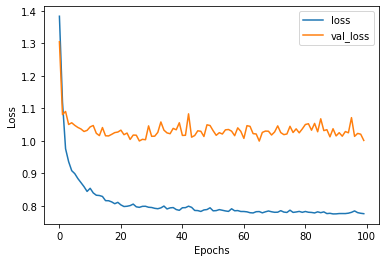

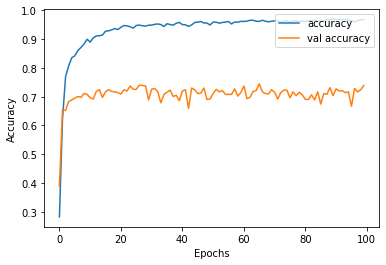

In [38]:
plot_learning_curve(history)

In [39]:
test_x = tokenizer(
    text=test['Comment'].to_list(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)

model_eval = model.evaluate(
    x={'input_ids': test_x['input_ids']},
    y=ytest
)

21/21 [==============================] - ETA: 0s - loss: 1.0550 - accuracy: 0.68 - ETA: 0s - loss: 1.1581 - accuracy: 0.58 - ETA: 0s - loss: 1.0715 - accuracy: 0.66 - ETA: 0s - loss: 1.0700 - accuracy: 0.66 - ETA: 0s - loss: 1.0632 - accuracy: 0.67 - ETA: 0s - loss: 1.0745 - accuracy: 0.66 - ETA: 0s - loss: 1.0829 - accuracy: 0.65 - ETA: 0s - loss: 1.0743 - accuracy: 0.66 - ETA: 0s - loss: 1.0782 - accuracy: 0.66 - ETA: 0s - loss: 1.0603 - accuracy: 0.67 - ETA: 0s - loss: 1.0649 - accuracy: 0.67 - 4s 190ms/step - loss: 1.0649 - accuracy: 0.6750


In [40]:
model_eval

[1.0648951530456543, 0.6749611496925354]

In [41]:
def prediction(model,tokenizer,input_string):
    
    padded_tokens = tokenizer(
    text=[input_string],
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)
    
    prediction = model.predict(padded_tokens['input_ids'])
    print(prediction)
    conversion_dict = {0:'joy',1:'fear',2:'anger',3:'sadness'}
    
    return conversion_dict[np.argmax(prediction)]

In [46]:
prediction(model, tokenizer, 'मै बहुत दुखी हूँ')

[[1.4651182e-05 2.9832927e-06 2.3604398e-05 9.9995875e-01]]


'sadness'

In [43]:
prediction(model, tokenizer, 'நான் மிகவும் மகிழ்ச்சியடைகிறேன்')

[[9.9999356e-01 6.9639157e-08 9.4152334e-08 6.1730898e-06]]


'joy'

In [44]:
# i am very annoyed at you
prediction(model, tokenizer, 'sono molto seccato con te')

[[1.9755298e-03 4.7100036e-04 8.3149022e-01 1.6606326e-01]]


'anger'

In [45]:
#someone is staring at me
prediction(model, tokenizer, "quelqu'un me regarde")

[[1.9299659e-05 1.6147927e-05 9.9941397e-01 5.5055722e-04]]


'anger'

In [47]:
# i saw a ghost
prediction(model, tokenizer, "j'ai vu un fantôme")

[[4.9013691e-04 9.9950981e-01 2.1698943e-08 5.7680211e-08]]


'fear'